# NEW SpikeInterface pipeline for NP2.0

We suggest running this new pipeline in a fresh environment with:

- spikeinterface>=0.93
- nwb-conversion-tools>=0.11.1

You can install all `spikeinterface` extended depenencies with:

`>>> pip install spikeinterface[full]`

In [88]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pprint import pprint

# core
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

# alternatively, all modules can be imported with 'flat' access with
# import spikeinterface.full as si

# new: sorting components
import spikeinterface.sortingcomponents as scp

%matplotlib notebook

## 1a) Load NP2.0 recording

In [4]:
base_path = Path("/home/alessio/Documents/data/catalyst/lab-data/brody/")
np_folder_data_path = base_path / "np2/M136_2021_12_06/M136_2021_12_06_homecage_shank1_1_g0"

### (optional) stub recording for fast testing; set to False for running processing pipeline on entire data

In [39]:
stub_test = False
nsec_stub = 10

In [40]:
recording = se.read_spikeglx(np_folder_data_path, stream_id="imec0.ap")
# similarly you can load imec1.ap

In [41]:
# new print function in SI
print(recording)

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 131.939s


<IPython.core.display.Javascript object>


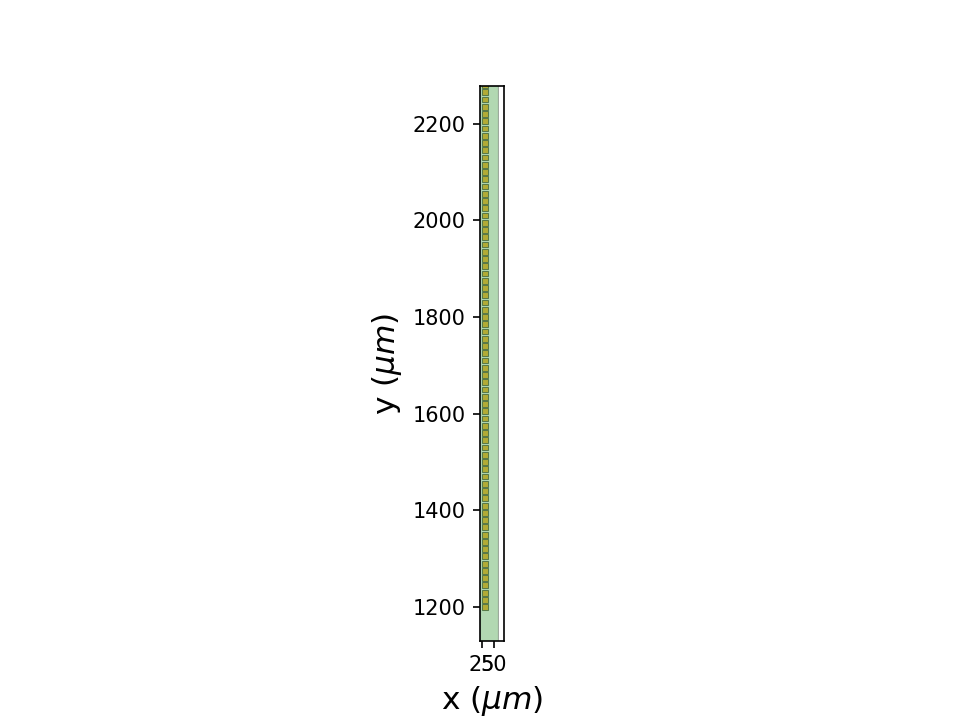

In [8]:
_ = sw.plot_probe_map(recording)

In [42]:
if stub_test:
    recording = recording.frame_slice(start_frame=0, end_frame=int(nsec_stub * recording.get_sampling_frequency()))

In [43]:
print(f"Sampling frequency: {recording.get_sampling_frequency()}")

Sampling frequency: 30000.0


***NOTE*** NP2.0 data is broad band!

### Inspect signals

<IPython.core.display.Javascript object>


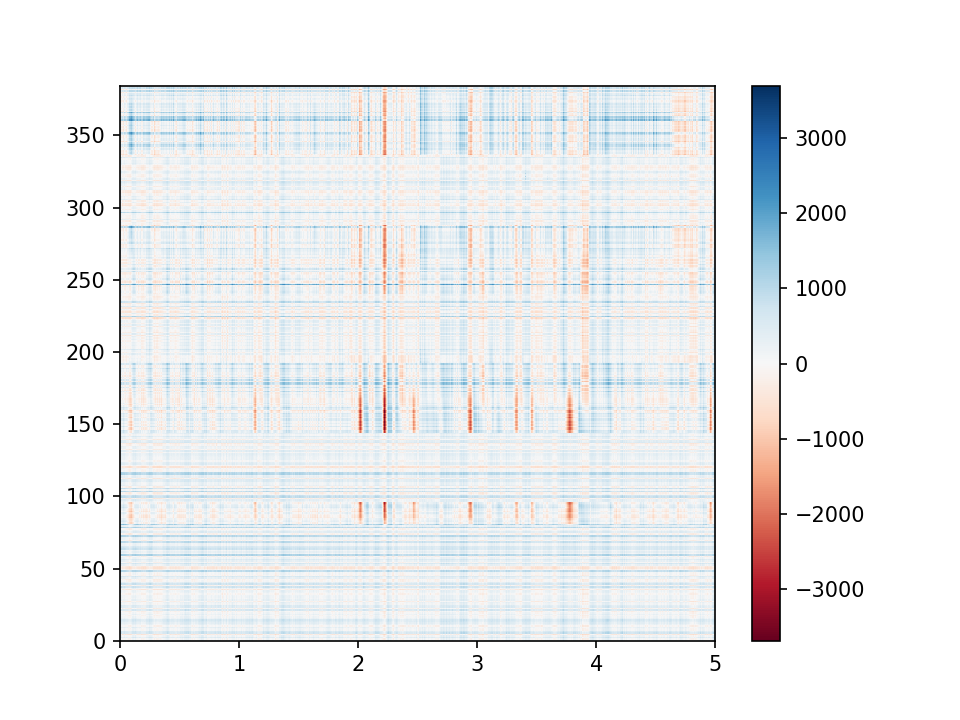

In [44]:
w_ts = sw.plot_timeseries(recording, time_range=[0, 5])

## 2) Pre-processing

In [45]:
# these will be used for parallelization
job_kwargs = {"n_jobs": 4, "chunk_duration": "1s", "progress_bar": True}

In [46]:
apply_filter = True
apply_cmr = True

In [47]:
if apply_filter:
    recording_processed = st.bandpass_filter(recording)
else:
    recording_processed = recording

In [48]:
if apply_cmr:
    recording_processed = st.common_reference(recording_processed, reference="global", operator="median")
else:
    recording_processed = recording

<IPython.core.display.Javascript object>


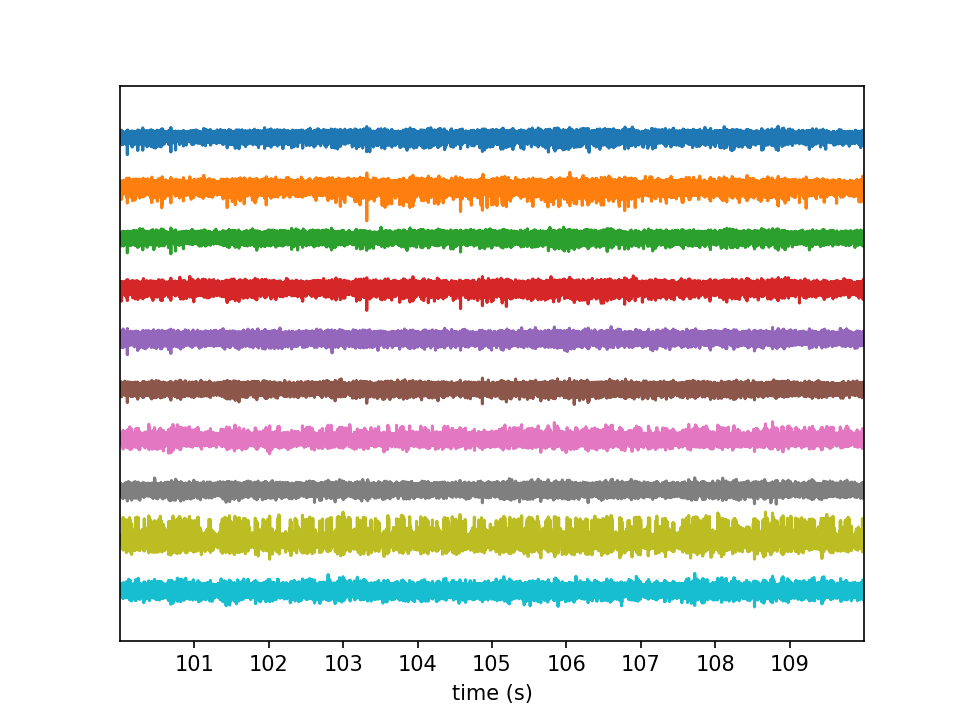

In [51]:
_ = sw.plot_timeseries(recording_processed, time_range=(100, 110), 
                       channel_ids=recording_processed.channel_ids[50:60])

In [52]:
peaks = scp.detect_peaks(recording_processed, **job_kwargs)

detect peaks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:21<00:00,  6.14it/s]


In [53]:
sw.plot_drift_over_time?

<IPython.core.display.Javascript object>


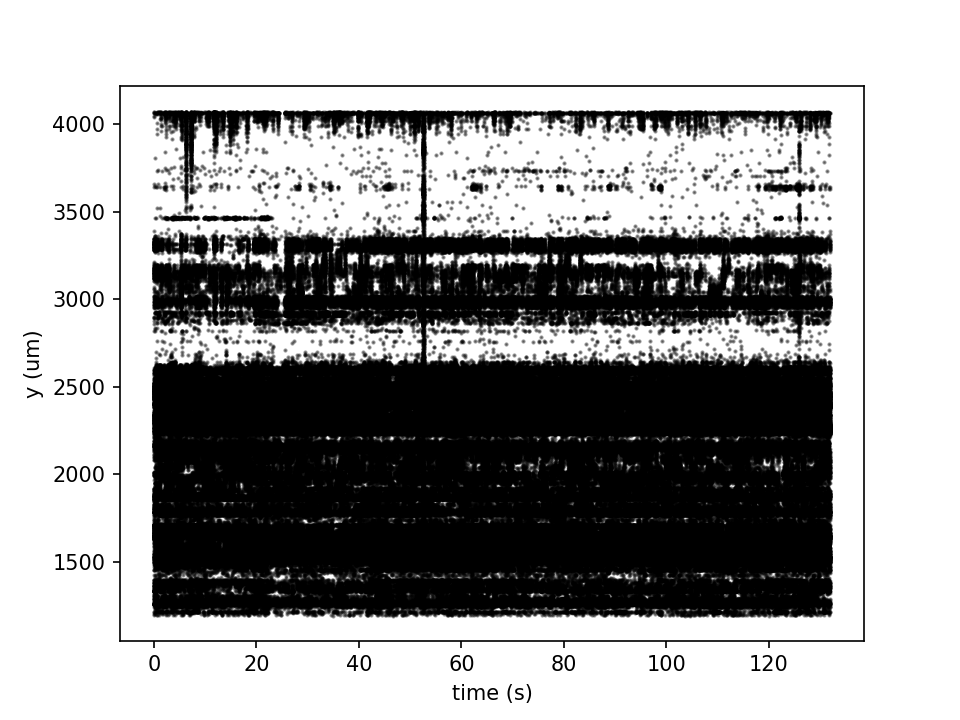

In [54]:
_ = sw.plot_drift_over_time(recording_processed, peaks=peaks, mode="scatter")

## 3) Run spike sorters

In [56]:
sorter_list = [
    "tridesclous",
    # "tridesclous",
    #'spykingcircus',
    # 'herdingspikes',
    #'kilosort2',
]

# ss.IronClustSorter.set_ironclust_path("D:/GitHub/ironclust")

In [57]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

tridesclous params description:
{'common_ref_removal': 'remove common reference with median',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of '
                'the spikes in the recording',
 'detect_threshold': 'Threshold for spike detection',
 'freq_max': 'Low-pass filter cutoff frequency',
 'freq_min': 'High-pass filter cutoff frequency',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'total_memory': 'Chunk size in Mb for saving to binary format (default 500Mb)'}
Default params:
{'common_ref_removal': False,
 'detect_sign': -1,
 'detect_threshold': 5,
 'freq_max': 5000.0,
 'freq_min': 400.0,
 'n_jobs_bin': 1,
 'nested_params': None,
 'total_memory': '500M'}


In [63]:
# user-specific parameters
sorter_params = dict(
    #kilosort2=dict(car=False, n_jobs_bin=12, chunk_mb=4000),
    #ironclust=dict(filter=True),
    tridesclous=dict(n_jobs_bin=job_kwargs["n_jobs"]),
    #spykingcircus=dict(filter=True, num_workers=16),
    #herdingspikes=dict(filter=True)
)

In [66]:
working_folder = Path(".") / "working"
if working_folder.is_dir():
    shutil.rmtree(working_folder)

In [67]:
sorting_outputs = ss.run_sorters(
    sorter_list=sorter_list, 
    recording_dict_or_list=dict(rec0=recording_processed),
    working_folder=working_folder,
    mode_if_folder_exists="overwrite", # change to "keep" to avoid repeating the spike sorting
    sorter_params=sorter_params,
    verbose=True,
    with_output=True
)

Local copy of recording


write_binary_recording: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.02it/s]


DataIO <id: 140641790709136> 
  workdir: working/rec0/tridesclous
  sample_rate: 30000.0
  total_channel: 384
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch380 ch381 ch382 ch383]
  nb_segment: 1
  length: 3958164
  durations: 131.9 s.
catalogue_nested_params
{'chunksize': 30000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 7680,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 131.9388,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
                       'wf_right_long_ms': 3.5,
      

In [68]:
# remove empty units (if any)
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    print(f"{sorter} found {len(sorting.get_unit_ids())} units")
    
    sorting_outputs[result_name] = sorting.remove_empty_units()

tridesclous found 102 units


Let's pick the output of tridesclous for the rest of the pipeline.

<IPython.core.display.Javascript object>


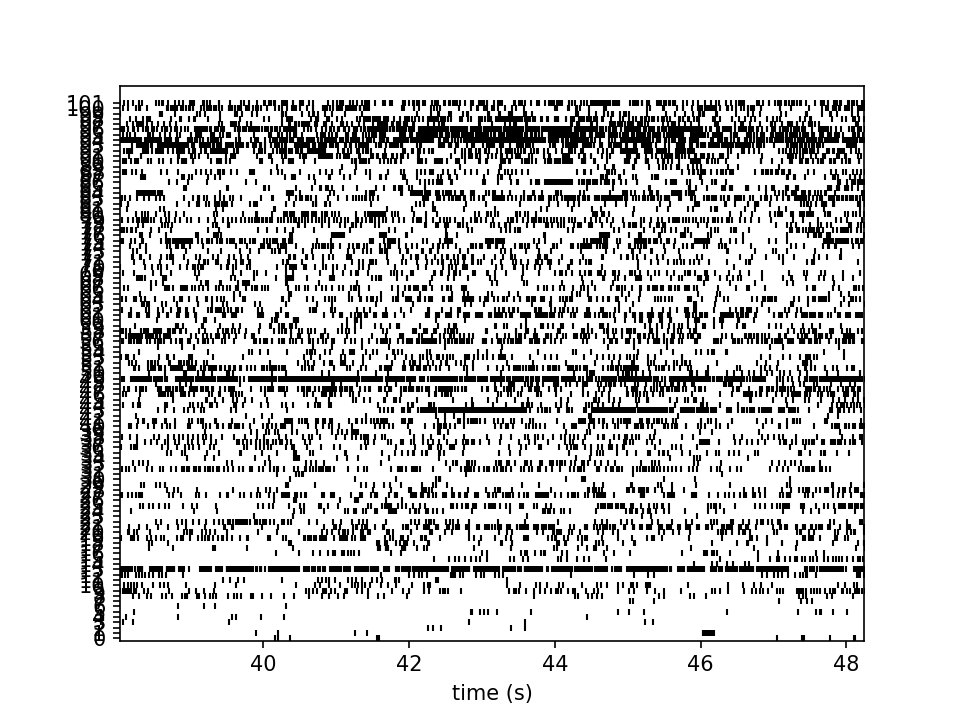

In [70]:
sorting_TDC = sorting_outputs[('rec0', 'tridesclous')]
_ = sw.plot_rasters(sorting_TDC)

## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

From SI>=0.90, a new `WaveformExtractor` object has been introduced. This is the foundation for the post-processing and curation.

In [73]:
waveform_folder = Path(".") / "waveforms_TDC"
we = si.extract_waveforms(recording_processed, sorting, folder=waveform_folder,
                          max_spikes_per_unit=500, **job_kwargs)

extract waveforms memmap: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:31<00:00,  4.16it/s]


In [74]:
# e.g., retrieve waveforms/templates
wf = we.get_waveforms(unit_id=sorting.unit_ids[0])
print(f"Waveforms shape: {wf.shape}")
template = we.get_template(unit_id=sorting.unit_ids[0])
print(f"Template shape: {template.shape}")

Waveforms shape: (106, 210, 384)
Template shape: (210, 384)


<IPython.core.display.Javascript object>


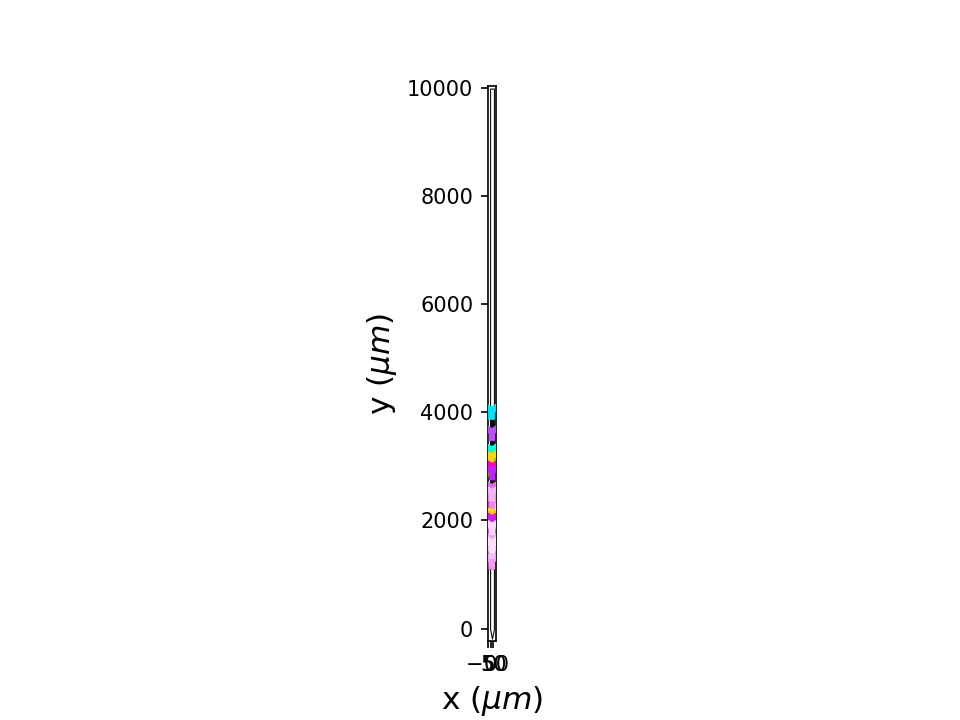

<IPython.core.display.Javascript object>


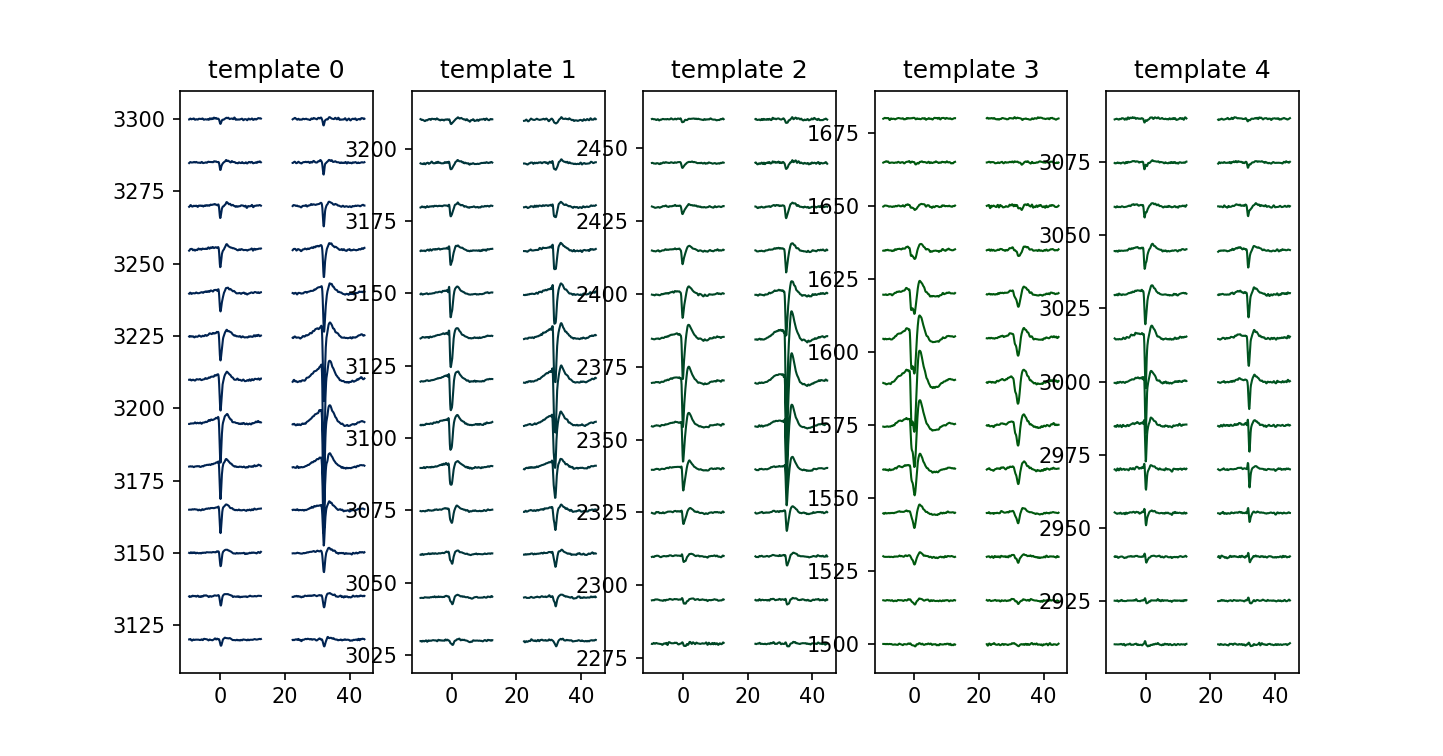

In [77]:
# some widgets
_ = sw.plot_unit_localization(we)

_ = sw.plot_unit_templates(we, unit_ids=sorting.unit_ids[:5], radius_um=100)

### Compute quality metrics

It's convenient to pre-compute PCA:

In [82]:
qc_list = st.get_quality_metric_list()
print(f"Available quality metrics: {qc_list}") 
# these don't include PC-based ones, which can be computed by passing a WaveformPrincipalComponent object

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [83]:
# (optional) define subset of qc
qc_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features

In [84]:
ec_list = st.get_template_metric_names()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [85]:
# (optional) define subset of ec
ec_list = ['peak_to_valley', 'halfwidth']

## Postprocess sorting output

### Template metrics (extracellular waveforms)

In [86]:
ec = st.calculate_template_metrics(we, upsample=10)

In [96]:
ec

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.00057,-0.183985,0.000187,1502622.597208,-79077.522415
1,0.00057,-0.281809,0.00028,764024.798352,-55464.965879
2,0.00051,-0.298504,0.000187,1282172.368393,-135453.731557
3,0.000513,-0.60893,0.000493,697685.314857,-145451.051166
4,0.00052,-0.208931,0.00016,717340.493778,-53466.970728
...,...,...,...,...,...
97,0.000157,-0.28055,0.000113,1125951.643918,-36414.096227
98,0.00014,-0.192686,0.000113,995278.437948,-10412.945572
99,0.000133,-0.309808,0.000107,1167402.439209,-11331.962811
100,0.000123,-0.397547,0.000097,1512050.054337,-25098.106321


### Quality metrics

In [98]:
qc = st.compute_quality_metrics(we, metric_names=qc_list)

In [99]:
qc

,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,firing_rate
0,21.611095,0.000000,0.000000,0,0.803403
1,16.564077,0.000000,0.000000,0,0.841299
2,18.087147,0.000000,0.000000,0,1.841763
3,11.553635,0.000000,0.000000,0,1.023202
4,14.573797,0.000000,0.000000,0,0.500232
...,...,...,...,...,...
97,6.194702,0.386475,0.257695,34,14.908427
98,5.457813,0.419106,0.295592,39,15.332866
99,5.929604,2.086152,0.341067,45,7.382211
100,7.152345,0.544278,0.712452,94,20.888473


### (Optional) QC with PCA

In [107]:
# pc = st.compute_principal_components(we)
# print(pc)
# qc_pc = st.compute_quality_metrics(we, **job_kwargs)
# display(qc_pc)

### Export to Phy (optional)

In [108]:
from spikeinterface.exporters import export_to_phy

In [111]:
phy_folder = Path(".") / "phy"
export_to_phy(we, output_folder=phy_folder, **job_kwargs)

write_binary_recording with n_jobs 4  chunk_size 30000


extract PCs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [01:10<00:00,  1.87it/s]


Run:
phy template-gui  /home/alessio/Documents/Codes/catalystneuro/lab-conversions/brody-lab-to-nwb/notebooks/phy/params.py


### Run phy and load curated data

In [ ]:
!phy template-gui phy phy/params.py

In [ ]:
sorting_manual_curated = se.read_phy(phy_folder, exclude_cluster_groups=['noise'])

In [ ]:
print(f"Sorter found {len(sorting_manual_curated.get_unit_ids())} units after manual curation")

## 5) Ensemble spike sorting

In [112]:
if len(sorting_outputs) > 1:
    # retrieve sortings and sorter names
    sorting_list = []
    sorter_names_comp = []
    for result_name, sorting in sorting_outputs.items():
        rec_name, sorter = result_name
        sorting_list.append(sorting)
        sorter_names_comp.append(sorter)
        
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names_comp)
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(mcmp)
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensemble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")
    
    sw.plot_rasters(sorting_ensemble)
else:
    print("Single sorter found. Ensemble spike sorting is unavailable")

Single sorter found. Ensemble spike sorting is unavailable


# 6) Automatic curation

Currently, automatic curation can be done by simply querying the `qc` table:

In [113]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 5
firing_rate_threshold = 0.1

In [121]:
curation_query = f"isi_violations_ratio < {isi_violation_threshold} and snr > {snr_threshold} and " \
                 f"firing_rate > {firing_rate_threshold}"

In [123]:
units_to_keep = qc.query(curation_query).index.values
sorting_curated = sorting.select_units(units_to_keep)

In [124]:
print(f"Num. units before: {len(sorting.unit_ids)}  --  Num. units after: {len(sorting_curated.unit_ids)}")

Num. units before: 102  --  Num. units after: 84


# 7) Save to NWB; writes only the spikes

In [ ]:
from nwb_conversion_tools.tools.spikeinterface import write_recording, write_sorting

In [126]:
# The name of the NWBFile containing behavioral or full recording data
nwbfile_path = Path(".") / "sorting_curated.nwb"

# Choose the sorting extractor from the notebook environment you would like to write to NWB
chosen_sorting_extractor = sorting_curated

write_sorting(
    sorting=chosen_sorting_extractor,
    save_path=nwbfile_path,
    overwrite=False,  # this appends the file. True would write a new file,
)